In [27]:
from charmAdjusted_deltaHedging import *
from scipy.stats import norm
from scipy import stats
from random import randint

In [111]:
# Hyperparameters
S0 = 36
sig = 0.1
mu = 0.00
r=0.05
K=36
_lambda = 1
n_sample = 100000
n_step = 100
dt=0.01
T = dt * n_step
Tau = np.zeros((n_sample, n_step))
Tau[:] = np.arange(0, T, dt)[::-1]

Text(0.5, 1.0, 'Stock Price')

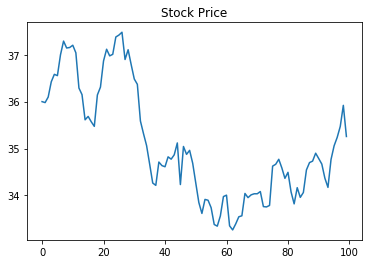

In [112]:
# Generate Stock Price
stock = Stock(n_sample=n_sample, n_step=n_step,
              S0=S0, sig=sig, r=mu, dt=dt)

plt.plot(stock.stock_price[0])
plt.title('Stock Price')

In [113]:
# Calculate Call Price Data
call_price = calculate_call_price(S = stock.stock_price,K=K, r=r, d=0, Tau=Tau, sig=sig)
delta = calculate_delta(S = stock.stock_price,K=K, r=r, d=0, Tau=Tau, sig=sig)
gamma = calculate_gamma(S = stock.stock_price,K=K, r=r, d=0, Tau=Tau, sig=sig)
charm = calculate_charm(S = stock.stock_price,K=K, r=r, d=0, Tau=Tau, sig=sig)

# Generate Riskfree Asset
bond_price = np.zeros((n_sample, n_step))
bond_price[:] = np.exp(r*np.arange(0, T, dt))

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:33: RuntimeWarning:

divide by zero encountered in true_divide

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:15: RuntimeWarning:

divide by zero encountered in true_divide

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:20: RuntimeWarning:

divide by zero encountered in true_divide

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:21: RuntimeWarning:

divide by zero encountered in true_divide

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:21: RuntimeWarning:

invalid value encountered in true_divide

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/Users/francis/Google Drive/00_IRTG1792/SFM1/to_git/charmAdjusted_deltaHedging.py:28: RuntimeWarning:

invalid value encounte

In [114]:
# Initial Delta Hedging
nS = delta[:, 0]
stock_value = nS * stock.stock_price[:, 0]

nB = (call_price[:,0] - stock_value)/bond_price[:,0]
bond_value = nB*bond_price[:,0]

portfolio_value = np.zeros((n_sample, n_step))
portfolio_value[:,0] = stock_value + bond_value

# Delta Hedging
HE = np.zeros((n_sample, n_step))
HE[:,0] = portfolio_value[:,0] - call_price[:,0]

for i in range(1, n_step):
    stock_value = nS * stock.stock_price[:, i]
    bond_value = nB * bond_price[:,i]
    portfolio_value[:,i] = stock_value + bond_value
    HE[:,i] = portfolio_value[:,i] - call_price[:,i]
    
    nS = delta[:, i]
    stock_value = nS * stock.stock_price[:, i]
    nB = (call_price[:,i] - stock_value)/bond_price[:,i]
    
# Charm Adjussted Delta Hedging

# Initial Delta Hedging
nS = delta[:, 0] + (_lambda * charm[:,0])
stock_value = nS * stock.stock_price[:, 0]

nB = (call_price[:,0] - stock_value)/bond_price[:,0]
bond_value = nB*bond_price[:,0]

portfolio_value = np.zeros((n_sample, n_step))
portfolio_value[:,0] = stock_value + bond_value

HE_c = np.zeros((n_sample, n_step))
HE_c[:,0] = portfolio_value[:,0] - call_price[:,0]

for i in range(1, n_step):
    stock_value = nS * stock.stock_price[:, i]
    bond_value = nB * bond_price[:,i]
    portfolio_value[:,i] = stock_value + bond_value
    HE_c[:,i] = portfolio_value[:,i] - call_price[:,i]
    
    nS = delta[:, i] + (_lambda * charm[:,i] * dt)
    stock_value = nS * stock.stock_price[:, i]
    nB = (call_price[:,i] - stock_value)/bond_price[:,i]

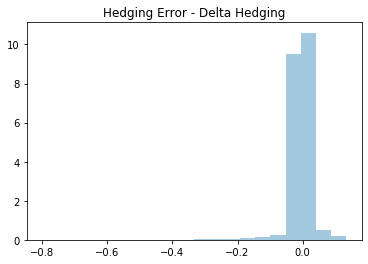

In [126]:
sns.distplot(HE[:,-1], bins=20, norm_hist=True, kde=False, hist=True)
plt.title('Hedging Error - Delta Hedging')
plt.savefig('hedgingError_DeltaHedging', transparent=True)

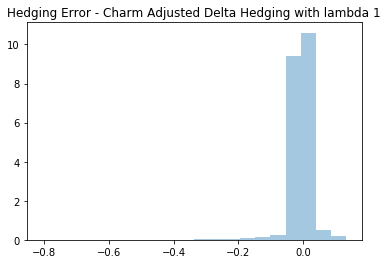

In [125]:
sns.distplot(HE_c[:,-1], bins=20, norm_hist=True, kde=False, hist=True)
plt.title('Hedging Error - Charm Adjusted Delta Hedging with lambda 1')
plt.savefig('hedgingError_charmAdjustedDeltaHedging', transparent=True)

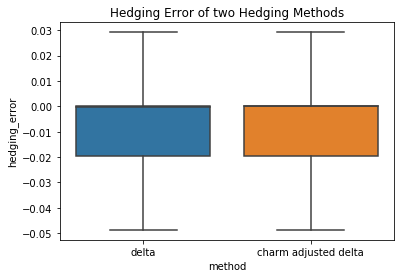

In [128]:
df1 = pd.DataFrame({'hedging_error':HE[:,-1]}) 
df1['method'] = 'delta'

df2 = pd.DataFrame({'hedging_error':HE_c[:,-1]}) 
df2['method'] = 'charm adjusted delta'

data = pd.concat([df1, df2], ignore_index=False)
data = data.reset_index(drop=True)

sns.boxplot(y='hedging_error', x='method', data=data, showfliers = False)
plt.title('Hedging Error of two Hedging Methods')
plt.savefig('hedgingError_compare', transparent=True)

In [169]:
stats.describe(HE[:,-1])

DescribeResult(nobs=100000, minmax=(-0.8005139526308938, 0.13457814911090082), mean=-0.009319162502785265, variance=0.0010633640471182132, skewness=-4.468542289548467, kurtosis=53.46613370360345)

In [170]:
stats.describe(HE_c[:,-1])

DescribeResult(nobs=100000, minmax=(-0.8066643346271221, 0.13454064771651986), mean=-0.00931716533800824, variance=0.0010633700335653021, skewness=-4.614019922489421, kurtosis=55.489940854273)

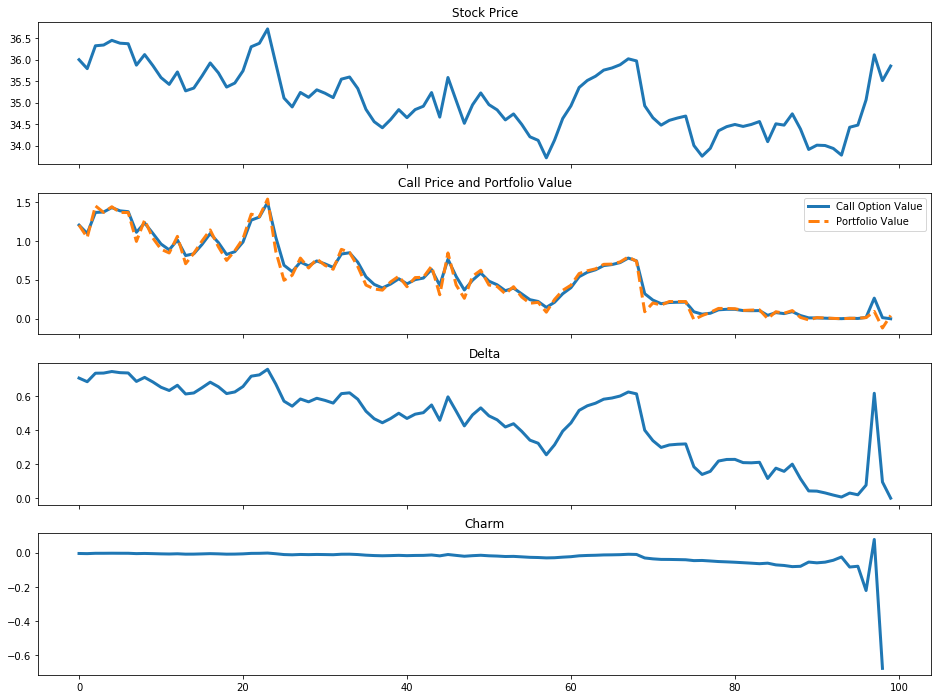

In [164]:
i=randint(0,n_sample)
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 12))
axs[0].plot(stock.stock_price[i], label='Stock Price', linewidth=3)
axs[0].set_title('Stock Price')

axs[1].plot(call_price[i], label='Call Option Value', linewidth=3)
axs[1].plot(portfolio_value[i], label='Portfolio Value', linestyle='--',linewidth=3)
axs[1].set_title('Call Price and Portfolio Value')
axs[1].legend()

axs[2].plot(delta[i], label='Delta', linewidth=3)
axs[2].set_title('Delta')

axs[3].plot(charm[i], label='Charm', linewidth=3)
axs[3].set_title('Charm')
plt.savefig('Charm Hedging Eaxmple 1', transparent=True)

In [168]:
# Record the trial number of the plots
i

13699

In [175]:
print('Delta  Hedging:',round(HE[i,-1], 6))
print('Charm Adjusted:',round(HE_c[i, -1],6))

Delta  Hedging: 0.044789
Charm Adjusted: 0.042612
